In [1]:
import autograd 
import autograd.numpy as np 

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp 
import matplotlib.pyplot as plt 

In [26]:
def hamiltonian(coords):
    q , p = np.split(coords, 2)
    #for an ideal mass-spring system, the hamiltonian is given by H = 1/2*k*q^2 + 1/(2m)*p^2
    H = (p**2 + q**2) #Acc to the code on the paper's repo
    return H 

def dynamics(t, coords):
    dcoords = autograd.grad(hamiltonian)(coords)
    dHdq, dHdp = np.split(dcoords, 2)
    S = np.concatenate([dHdp,-dHdq]) #(dq/dt, dp/dt) = (dH/dp, -dH/dq )
    return S 

In [27]:
# Test point: q=1, p=0
test_coords = np.array([1.0, 0.0])
result = dynamics(None, test_coords)
print(f"At q=1, p=0: dynamics = {result}")

# For a harmonic oscillator H = (q² + p²)/2
# Expected: dq/dt = p = 0, dp/dt = -q = -1
# So result should be [0, -1]

At q=1, p=0: dynamics = [ 0. -2.]


In [28]:
# Test your hamiltonian at the same point
test_coords = np.array([1.0, 0.0])
H_value = hamiltonian(test_coords)
print(f"Hamiltonian at q=1, p=0: {H_value}")
# For harmonic oscillator, should be 0.5

Hamiltonian at q=1, p=0: [1.]


In [29]:
def trajectory(t_span=[0,3], timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs):
    #creating the different time steps for the trajectories 
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

    #getting intial state 
    if y0 is None:
        y0 = np.random.rand(2)*2-1 #samples between -1 and 1
    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 
    y0 = y0/np.linalg.norm(y0) * radius 
    # In Hamiltonian systems where:
    #     H(q, p) = q^2 + p^2
    # the total energy of a state (q, p) is proportional to the squared distance
    # from the origin in phase space.
    # So when we normalize y0 (which is [q, p]) and rescale it to a fixed radius:
    # we are projecting the point onto a circle (or energy shell) of fixed total energy.
    # This ensures that all sampled initial conditions lie on a constant-energy
    # shell, which is useful when generating trajectories with controlled and
    # uniformly distributed energy levels for training or testing HamiltonianNNs

    spring_ivp = solve_ivp(fun=dynamics, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q , p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T 
    dqdt, dpdt = np.split(dydt,2) 

    #adding noise to the values of q and p 
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std

    return q, p, dqdt, dpdt, t_eval, dydt 

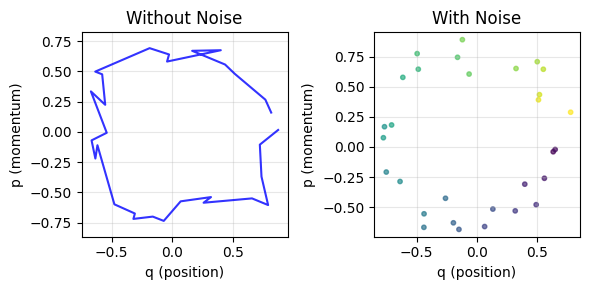

In [32]:
# Generate clean trajectory for comparison
np.random.seed(0)
q_clean, p_clean, _, _, t_clean, _ = trajectory(radius=0.7, y0=np.array([1,0]), noise_std=0.1)

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.plot(q_clean.squeeze(), p_clean.squeeze(), 'b-', alpha=0.8, label='Clean trajectory')
plt.xlabel('q (position)')
plt.ylabel('p (momentum)')
plt.title('Without Noise')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
q_noisy, p_noisy, _, _, t_noisy, _ = trajectory(radius=0.7, y0=np.array([1,0]), noise_std=0.1)
plt.scatter(q_noisy.squeeze(), p_noisy.squeeze(), c=t_noisy, s=10, alpha=0.7)
plt.xlabel('q (position)')
plt.ylabel('p (momentum)')
plt.title('With Noise')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# In your trajectory function, what's the default t_span?
q, p, dqdt, dpdt, t_eval, dydt = trajectory(radius=0.7, y0=np.array([1,0]))
print(f"Time span: {t_eval[0]} to {t_eval[-1]}")
print(f"Period estimate: {2*np.pi}")  # For unit frequency harmonic oscillator

Time span: 0.0 to 3.0
Period estimate: 6.283185307179586


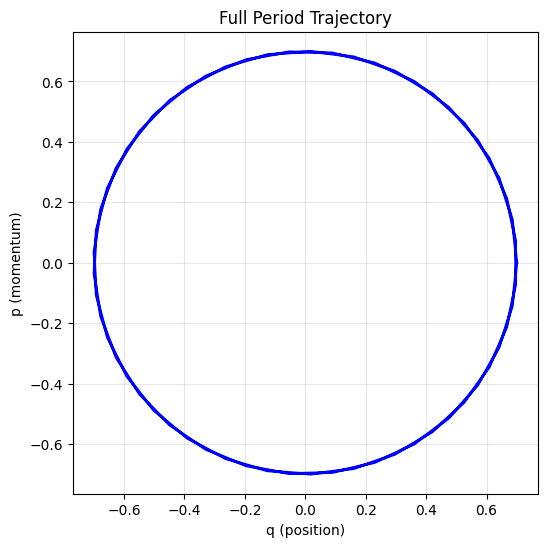

In [35]:
# Test with longer time to complete full orbits
q_full, p_full, _, _, t_full, _ = trajectory(
    radius=0.7, 
    y0=np.array([1,0]), 
    t_span=[0, 2*np.pi],  # Full period for harmonic oscillator
    noise_std=0.0
)

plt.figure(figsize=(6,6))
plt.plot(q_full.squeeze(), p_full.squeeze(), 'b-', linewidth=2)
plt.xlabel('q (position)')
plt.ylabel('p (momentum)')
plt.title('Full Period Trajectory')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

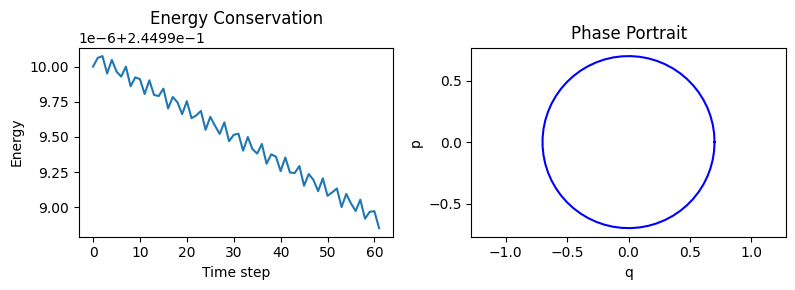

In [25]:
# Check if energy is conserved (should be constant)
q_clean, p_clean, _, _, _, _ = trajectory(radius=0.7, y0=np.array([1,0]), t_span=[0, 2*np.pi],noise_std=0.0)
energy = []
for i in range(len(q_clean.squeeze())):
    coords = np.array([q_clean.squeeze()[i], p_clean.squeeze()[i]])
    energy.append(hamiltonian(coords))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(energy)
plt.title('Energy Conservation')
plt.ylabel('Energy')
plt.xlabel('Time step')

plt.subplot(1,2,2)
plt.plot(q_clean.squeeze(), p_clean.squeeze(), 'b-')
plt.title('Phase Portrait')
plt.xlabel('q')
plt.ylabel('p')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
q,p, dqdt, dpdt, t_eval, dydt = trajectory()


In [8]:
q, p

(array([-0.184672  , -0.15501121, -0.34821319, -0.2155834 , -0.2333525 ,
        -0.05046217,  0.07063946,  0.03116505, -0.01085185, -0.0037668 ,
         0.14189907, -0.00191735,  0.21609627,  0.11134961,  0.3030605 ,
         0.2605222 ,  0.27044253,  0.25006356,  0.32866583,  0.44178277,
         0.50825753,  0.46989919,  0.56256479,  0.68445715,  0.39785338,
         0.40487668,  0.2720708 ,  0.5213107 ,  0.51404003,  0.2751412 ]),
 array([ 0.34463326,  0.43664488,  0.36626777,  0.45340573,  0.40723421,
         0.28498332,  0.52417312,  0.5598364 ,  0.50429425,  0.33430597,
         0.34895463,  0.30081236,  0.47621043,  0.50714092,  0.3997737 ,
         0.4245811 ,  0.21343193,  0.28124116,  0.09327556,  0.1142303 ,
         0.23837515,  0.08403828,  0.18527116,  0.07377665,  0.24885657,
        -0.05951245, -0.25309599, -0.1582729 , -0.29183046, -0.13642913]))

In [9]:
q.shape, p.shape 

((30,), (30,))

In [10]:
dpdt, dqdt

(array([[ 0.32519253,  0.29424378,  0.26014911,  0.2232729 ,  0.18400926,
          0.14277843,  0.10002103,  0.05619389,  0.01176628, -0.03278713,
         -0.07699039, -0.12037   , -0.16246267, -0.2028187 , -0.24100567,
         -0.27661593, -0.30926897, -0.3386148 , -0.36434033, -0.3861706 ,
         -0.40387147, -0.41725438, -0.42617614, -0.43054088, -0.43030247,
         -0.42546335, -0.41607494, -0.40223798, -0.38410035, -0.36185582]]),
 array([[ 0.28286918,  0.3149378 ,  0.34363894,  0.36866558,  0.3897509 ,
          0.40666881,  0.41923838,  0.42732584,  0.43084414,  0.4297557 ,
          0.42407258,  0.41385516,  0.39921269,  0.38030197,  0.35732507,
          0.33052754,  0.30019604,  0.26665497,  0.23026267,  0.19140838,
          0.15050779,  0.10799773,  0.06433296,  0.01998065, -0.02458565,
         -0.068889  , -0.11245546, -0.15481994, -0.1955289 , -0.23414713]]))

In [11]:
dpdt.shape, dqdt.shape


((1, 30), (1, 30))

In [12]:
dydt, dydt.shape

(array([[ 0.28286918,  0.3149378 ,  0.34363894,  0.36866558,  0.3897509 ,
          0.40666881,  0.41923838,  0.42732584,  0.43084414,  0.4297557 ,
          0.42407258,  0.41385516,  0.39921269,  0.38030197,  0.35732507,
          0.33052754,  0.30019604,  0.26665497,  0.23026267,  0.19140838,
          0.15050779,  0.10799773,  0.06433296,  0.01998065, -0.02458565,
         -0.068889  , -0.11245546, -0.15481994, -0.1955289 , -0.23414713],
        [ 0.32519253,  0.29424378,  0.26014911,  0.2232729 ,  0.18400926,
          0.14277843,  0.10002103,  0.05619389,  0.01176628, -0.03278713,
         -0.07699039, -0.12037   , -0.16246267, -0.2028187 , -0.24100567,
         -0.27661593, -0.30926897, -0.3386148 , -0.36434033, -0.3861706 ,
         -0.40387147, -0.41725438, -0.42617614, -0.43054088, -0.43030247,
         -0.42546335, -0.41607494, -0.40223798, -0.38410035, -0.36185582]]),
 (2, 30))

In [13]:
t_eval 

array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
       0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
       1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
       1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
       2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
       2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ])

In [14]:
t_eval.shape

(30,)

In [15]:
def get_dataset(seed, samples=50, test_split=0.5, **kwargs):
    data = {'meta':locals()} 

    #randomly sampling inputs 
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = trajectory(**kwargs)
        xs.append(np.stack([x,y]).T)
        dxs.append(np.stack([dx, dy]).T)
    
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze() #acc to the repo code 

    #making the train test split 
    split_ix = int(len(data['x'])*test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data['train_'+k], split_data['test_'+k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data 

In [16]:
data = get_dataset(seed=69)
data 

ValueError: too many values to unpack (expected 5)

In [ ]:
data['train_x'].shape

(750, 2)

In [ ]:
data['train_dx'].shape

(750, 2)